# IOR benchmark with pdwfs

https://ior.readthedocs.io/en/latest/userDoc/tutorial.html#getting-started-with-ior

## Benchmark script template

In [13]:
%%bash
cat ior_script.jinja2

IOR START
  api={{ api }}
  verbose=0
  testFile=testFile
  writeFile=1
  readFile={{ read }}
{% for case in cases %}
RUN
  numTasks={{ case.numTasks }}
  filePerProc={{ case.filePerProc }}
  collective={{ case.collective }}
  segmentCount={{ case.segmentCount }}
  blockSize={{ case.transferSize }}
  transferSize={{ case.transferSize }}
{% endfor %}
IOR STOP

![IOR](https://ior.readthedocs.io/en/latest/_images/tutorial-ior-io-pattern.png)

## Benchmark script builder

In [14]:
import itertools as it
from collections import namedtuple
from jinja2 import Template

IORCase = namedtuple("IORCase", ["numTasks", "filePerProc", "collective", "segmentCount", "transferSize"])

def make_ior_script(api, numTasks, filePerProc, collective, segmentCount, transferSize, read):
    matrix = list(it.product(numTasks, filePerProc, collective, segmentCount, transferSize))
    cases = [IORCase(*case) for case in matrix]

    with open("ior_script.jinja2", "r") as f:
        template = Template(f.read())

    with open("ior_script", "w") as f:
        f.write(template.render(api=api, cases=cases, read=read))

## Results parser (Pandas dataframe)

In [15]:
def parse_ior_results(filename):
    """
    Parse IOR results in file given by filename and return a Pandas dataframe
    """
    import re
    import pandas

    start_line = None
    end_line = None
    with open(filename,'r') as f: 
        for i, line in enumerate(f.readlines()):
            if re.search("Summary of all tests:", line):
                 start_line = i + 1
            if re.search("Finished", line):
                end_line = i - 1

    return pandas.read_csv(filename, sep='\s+', skiprows=start_line, nrows=end_line-start_line)

## Benchmark

### Build IOR script

In [36]:
# Global parameters
api = "POSIX"  # possible values: POSIX, MPIIO, HDF5 
read = "0"

# Case parameters
numTasks=["2"]
filePerProc=["0"]
collective=["1"]
segmentCount=["1"]
transferSize = ["512k", "1m", "5m", "10m", "50m", "100m", "250m"]

make_ior_script(api, numTasks, filePerProc, collective, segmentCount, transferSize, read)
#%cat ior_script

### Run on disk

In [37]:
%%bash 
cd run
mpirun ior -f ../ior_script > ior_results_disk.out
# %cat ior_results_disk.out

### Run with pdwfs

In [54]:
%%bash
cd run
pdwfs-redis restart &> /dev/null
pdwfs -p . -- mpirun ior -f ../ior_script > ior_results_pdwfs.out
# %cat ior_results_pdwfs.out

### Parse results

In [55]:
df_disk = parse_ior_results("run/ior_results_disk.out")
#df_disk

In [56]:
df_pdwfs = parse_ior_results("run/ior_results_pdwfs.out")
#df_pdwfs

### Plot results

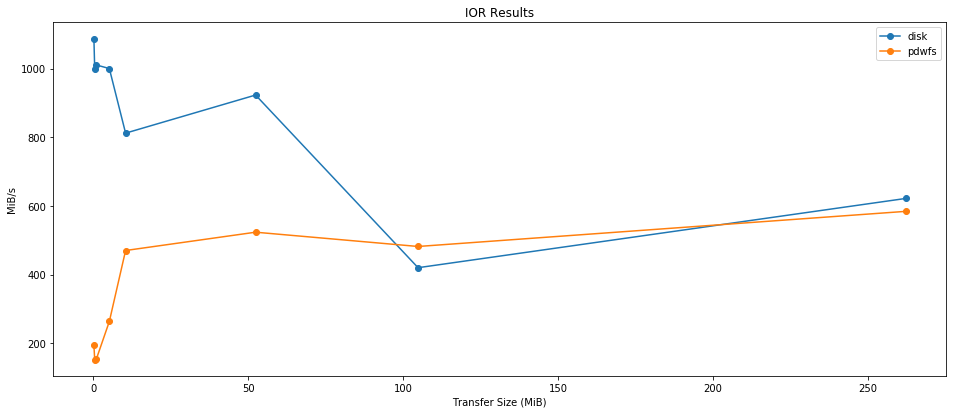

In [57]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

plt.xlabel("Transfer Size (MiB)")
plt.ylabel("MiB/s")
plt.title("IOR Results")

fig = plt.gcf()
fig.set_size_inches(16, 6.5)

plt.plot(df_disk["xsize"] / 1.e6, df_disk["Max(MiB)"],'-o',label="disk")
plt.plot(df_pdwfs["xsize"] / 1.e6, df_pdwfs["Max(MiB)"],'-o',label="pdwfs")

plt.legend(["disk","pdwfs"],loc="upper right")

## Example with multipe Redis instances

In [22]:
%%bash
cd run
redis-cli -p 6379 shutdown 2> /dev/null
redis-cli -p 6380 shutdown 2> /dev/null
redis-cli -p 6381 shutdown 2> /dev/null
redis-server --daemonize yes --save "" --port 6379
redis-server --daemonize yes --save "" --port 6380
redis-server --daemonize yes --save "" --port 6381
export PDWFS_REDIS=":6379,:6380,:6381"
export PDWFS_BLOCKSIZE="250"
pdwfs -p . -- mpirun ior -a MPIIO -t 250m -b 250m

128:C 22 Mar 2019 14:24:06.966 # oO0OoO0OoO0Oo Redis is starting oO0OoO0OoO0Oo
128:C 22 Mar 2019 14:24:06.967 # Redis version=5.0.3, bits=64, commit=00000000, modified=0, pid=128, just started
128:C 22 Mar 2019 14:24:06.967 # Configuration loaded
130:C 22 Mar 2019 14:24:06.969 # oO0OoO0OoO0Oo Redis is starting oO0OoO0OoO0Oo
130:C 22 Mar 2019 14:24:06.969 # Redis version=5.0.3, bits=64, commit=00000000, modified=0, pid=130, just started
130:C 22 Mar 2019 14:24:06.969 # Configuration loaded
135:C 22 Mar 2019 14:24:06.972 # oO0OoO0OoO0Oo Redis is starting oO0OoO0OoO0Oo
135:C 22 Mar 2019 14:24:06.972 # Redis version=5.0.3, bits=64, commit=00000000, modified=0, pid=135, just started
135:C 22 Mar 2019 14:24:06.972 # Configuration loaded
BlockSize:  262144000
BlockSize:  262144000
BlockSize:  262144000
IOR-3.2.0: MPI Coordinated Test of Parallel I/O
Began               : Fri Mar 22 14:24:07 2019
Command line        : ior -a MPIIO -t 250m -b 250m
Machine             : Linux ff981a9089a8
TestID